### Setting Up Environment

In [137]:
import sys
print(sys.executable)

/ifshome/psenthilkumar/.conda/envs/synthbrain/bin/python


In [56]:
!pip install -q "monai-weekly[tqdm, nibabel]" matplotlib

In [57]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [58]:
import sys
import os
print(sys.path)

['/ifshome/psenthilkumar/SYN', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python38.zip', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/lib-dynload', '', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/IPython/extensions', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/setuptools/_vendor', '/ifshome/psenthilkumar/.ipython']


In [59]:
print(os.getcwd())

/ifshome/psenthilkumar/SYN/synth_2


In [60]:
os.chdir('/ifshome/psenthilkumar/SYN/synth_2')

# Verify the change
print(os.getcwd())

/ifshome/psenthilkumar/SYN/synth_2


In [61]:
from generative.networks.nets import VQVAE

# Check if it was imported without error
print(VQVAE)

<class 'generative.networks.nets.vqvae.VQVAE'>


In [62]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.nn import L1Loss
from tqdm import tqdm
from generative.networks.nets import VQVAE

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /ifshome/<username>/.conda/envs/synthbrain/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 10.4.0
Tensorboard version: 2.14.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.


In [63]:
import monai
dir(monai.networks.nets)

['AHNet',
 'AHnet',
 'Ahnet',
 'AttentionUnet',
 'AutoEncoder',
 'BasicUNet',
 'BasicUNetPlusPlus',
 'BasicUnet',
 'BasicUnetPlusPlus',
 'Basicunet',
 'BasicunetPlusPlus',
 'BertAttention',
 'BertMixedLayer',
 'BertOutput',
 'BertPreTrainedModel',
 'BlockArgs',
 'Classifier',
 'Critic',
 'DAF3D',
 'DenseNet',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'DenseNet264',
 'Densenet',
 'Densenet121',
 'Densenet169',
 'Densenet201',
 'Densenet264',
 'DiNTS',
 'Discriminator',
 'DynUNet',
 'DynUnet',
 'Dynunet',
 'EfficientNet',
 'EfficientNetBN',
 'EfficientNetBNFeatures',
 'EfficientNetEncoder',
 'FLEXUNET_BACKBONE',
 'FlexUNet',
 'FlexUNetEncoderRegister',
 'FlexibleUNet',
 'FullyConnectedNet',
 'Generator',
 'GlobalNet',
 'HighResBlock',
 'HighResNet',
 'HoVerNet',
 'HoVernet',
 'HoverNet',
 'Hovernet',
 'LocalNet',
 'MILModel',
 'MultiModal',
 'NetAdapter',
 'PatchMerging',
 'PatchMergingV2',
 'Pooler',
 'Quicknat',
 'RegUNet',
 'Regressor',
 'ResNet',
 'ResNetBlock',
 'ResNetBottle

In [64]:
import monai
print(monai.__file__)

/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/monai/__init__.py


In [65]:
import os
import monai

path_to_monai = os.path.dirname(monai.__file__)
print(f"MONAI is installed at: {path_to_monai}")
print("Generative submodule exists:", os.path.isdir(os.path.join(path_to_monai, "generative")))

MONAI is installed at: /ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/monai
Generative submodule exists: False


In [66]:
import monai
print(monai.__version__)

1.3.0


In [67]:
from generative.networks.nets import VQVAE
print("VQVAE successfully imported!")

VQVAE successfully imported!


### Setting Up

In [68]:
# for reproducibility purposes set a seed
set_determinism(42)

### Temporary Folder creation

In [69]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpgvuxc9oq


In [95]:
import os

files = os.listdir(root_dir)
print("Files in the directory:", files)

Files in the directory: ['Task01_BrainTumour.tar', 'Task01_BrainTumour']


In [70]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
    
    ## try diff dim spatial_size=(32, 48, 32)
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(32, 48, 32)),
    ]
)

##### Loading images (LoadImaged).
##### Extracting the second channel (Lambdad).
##### Ensuring channel-first format (EnsureChannelFirstd).
##### Scaling intensity values (ScaleIntensityd).
##### Performing a center crop (CenterSpatialCropd).
##### Resizing to a smaller spatial size (Resized).

In [71]:
train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform, section="training", download=True
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform, section="validation", download=True
)

val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=8, persistent_workers=True)

Task01_BrainTumour.tar: 7.09GB [05:43, 22.2MB/s]                                

2025-01-21 12:05:32,507 - INFO - Downloaded: /tmp/tmpgvuxc9oq/Task01_BrainTumour.tar


2025-01-21 12:05:46,947 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-01-21 12:05:46,949 - INFO - Writing into directory: /tmp/tmpgvuxc9oq.


Loading dataset: 100%|██████████| 388/388 [07:38<00:00,  1.18s/it]


2025-01-21 12:13:49,412 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-01-21 12:13:49,413 - INFO - File exists: /tmp/tmpgvuxc9oq/Task01_BrainTumour.tar, skipped downloading.
2025-01-21 12:13:49,414 - INFO - Non-empty folder exists in /tmp/tmpgvuxc9oq/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [01:57<00:00,  1.22s/it]


In [104]:
print(type(train_ds[0]))

<class 'dict'>


In [107]:
train_ds[2]

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [108]:
nift='/tmp/tmpgvuxc9oq/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz'

In [110]:
import nibabel as nib
import matplotlib.pyplot as plt
nifti_file = '/tmp/tmpgvuxc9oq/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz'
img = nib.load(nifti_file)

# Get the image data as a Numpy array
data = img.get_fdata()

# Print shape and data type
print("Shape of data:", data.shape)  # 3D (x, y, z) or 4D (x, y, z, time)
print("Data type:", data.dtype)

Shape of data: (240, 240, 155)
Data type: float64


In [111]:
z_mid = data.shape[2] // 2
slice_2d = data[:, :, z_mid]  # Extract the 2D slice

# Normalize the slice for visualization (optional)
slice_2d_normalized = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())

/tmp/ipykernel_149531/1980245569.py:5: RuntimeWarning: invalid value encountered in divide
  slice_2d_normalized = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())


In [112]:
from PIL import Image
import numpy as np

# Convert the normalized slice to an 8-bit image
slice_2d_uint8 = (slice_2d_normalized * 255).astype(np.uint8)

# Save using Pillow
output_file = 'slice_z_mid.png'
Image.fromarray(slice_2d_uint8).save(output_file)

print(f"Saved slice as {output_file}")

Saved slice as slice_z_mid.png


/tmp/ipykernel_149531/2141275121.py:5: RuntimeWarning: invalid value encountered in cast
  slice_2d_uint8 = (slice_2d_normalized * 255).astype(np.uint8)


In [72]:
len(train_ds)

388

In [85]:
for i in train_loader:
    print(i['image'].shape)

torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([16, 1, 32, 48, 32])
torch.Size([4, 1, 32, 48, 32])


In [73]:
len(val_ds)

96

### Check and visualize

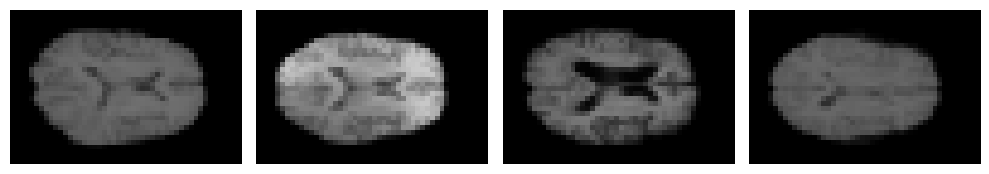

In [77]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [131]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [1]:
import torch
print(torch.__version__)


2.1.0+cu121


In [2]:
import torchvision
print(torchvision.__version__)


0.16.0+cu121


#### Define Network 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 256),
    num_res_channels=256,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=256,
    embedding_dim=32,
    ## try changing codebook dim 
)
model.to(device)

In [88]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
## diff lr
l1_loss = L1Loss()

#### Model Training 

In [89]:
# n_epochs = 100
n_epochs = 50
## more epochs
val_interval = 5
epoch_recon_loss_list = []
epoch_quant_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = model(images=images)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_quant_loss_list.append(quantization_loss.item() / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)

                # get the first sample from the first validation batch for
                # visualizing how the training evolves
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 49: 100%|████████████████| 25/25 [04:02<00:00,  9.69s/it, recons_loss=0.0091, quantization_loss=4.79e-6]


train completed, total time: 12311.376657247543.


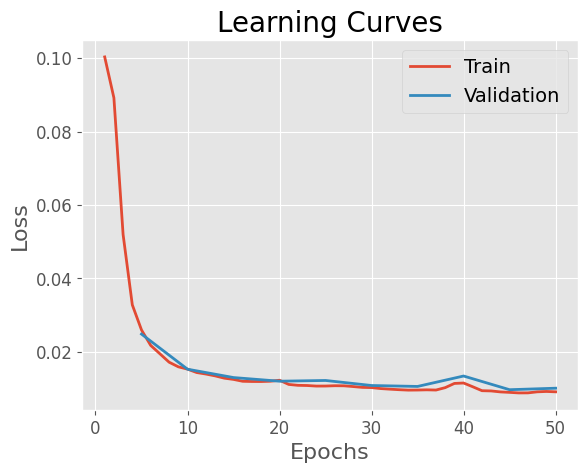

In [90]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])


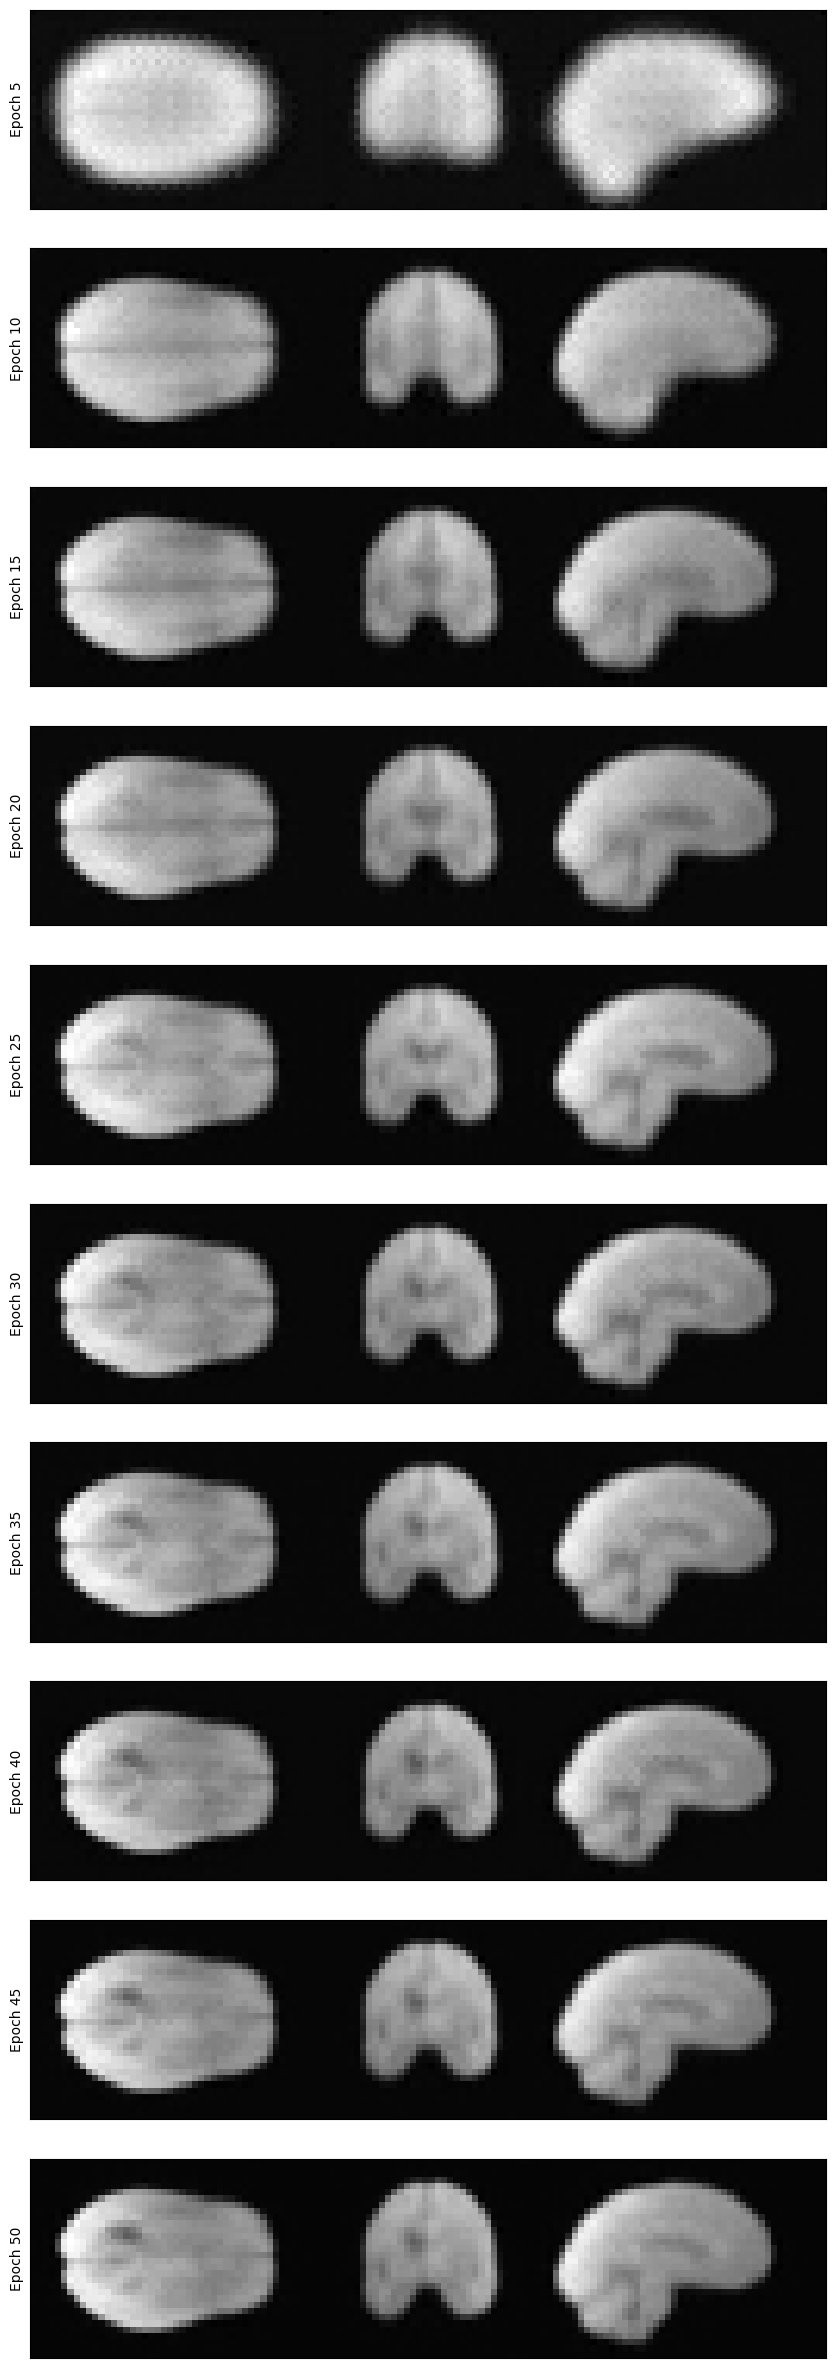

In [93]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(18.5, 30.5)
for image_n in range(len(val_samples)):
    reconstructions = intermediary_images[image_n]
    print(reconstructions.shape)
    reconstructions = np.concatenate(
        [
            reconstructions[0, :, :, 15],
            np.flipud(reconstructions[0, :, 24, :].T),
            np.flipud(reconstructions[0, 15, :, :].T),
        ],
        axis=1,
    )

    ax[image_n].imshow(reconstructions, cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

#### Plotting reconstructions 

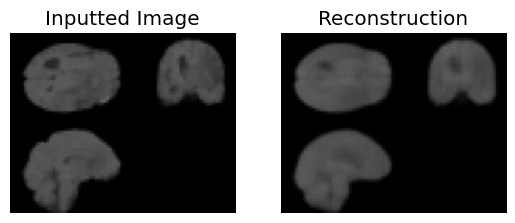

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.style.use("default")
plotting_image_0 = np.concatenate([images[0, 0, :, :, 15].cpu(), np.flipud(images[0, 0, :, 24, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(images[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
image = np.concatenate([plotting_image_0, plotting_image_1], axis=0)

ax[0].imshow(image, vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")

plotting_image_2 = np.concatenate(
    [reconstruction[0, 0, :, :, 15].cpu(), np.flipud(reconstruction[0, 0, :, 24, :].cpu().T)], axis=1
)
plotting_image_3 = np.concatenate([np.flipud(reconstruction[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
reconstruction_3d = np.concatenate([plotting_image_2, plotting_image_3], axis=0)
ax[1].imshow(reconstruction_3d, vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()